# Tarea 5

Luego de descargar las imágenes en los filtros F475W y F850LP del objeto VCC1316 (M87) se siguen los pasos de la primera tarea para generar el catálogo.
De [Sirianni et. al (2005)](http://adsabs.harvard.edu/abs/2005PASP..117.1049S]) se obtiene la escala de WFC (0.05''/px) y los zeropoint en el sistema AB (según la tabla 10) y se ejecuta Sextractor.
Se corrige por apertura según la tabla 3 (2 pixeles de radio a escala de 0.05''/px corresponden a 0.1'').
Se corrige por reddening (para un SED tipo E) según la tabla 14 y el valor (B-V) de [NED](https://ned.ipac.caltech.edu/cgi-bin/objsearch?objname=m87&extend=no&hconst=73&omegam=0.27&omegav=0.73&corr_z=1&out_csys=Equatorial&out_equinox=J2000.0&obj_sort=RA+or+Longitude&of=pre_text&zv_breaker=30000.0&list_limit=5&img_stamp=YES)


In [1]:
from astropy.io import fits
import numpy as np

f475 = fits.open('hst_9401_02_acs_wfc_f475w_drz.fits')
f850 = fits.open('hst_9401_02_acs_wfc_f850lp_drz.fits')

f475[1].writeto('sci_f475w_m87.fits',clobber=True)
f475[2].writeto('invvar_f475w_m87.fits',clobber=True)

f850[1].writeto('sci_f850lp_m87.fits',clobber=True)
f850[2].writeto('invvar_f850lp_m87.fits',clobber=True)

f475.close()
f850.close()

In [2]:
!sextractor sci_f475w_m87.fits -c f475w.sex
!sextractor sci_f850lp_m87.fits -c f850lp.sex

> 
----- SExtractor 2.19.5 started on 2016-11-28 at 23:14:04 with 1 thread

> Setting catalog parameters
> Reading detection filter
> Initializing check-image(s)
> Initializing catalog
> Looking for sci_f475w_m87.fits
----- Measuring from: sci_f475w_m87.fits [1/1]
      "Unnamed" / no ext. header / 4238x4213 / 32 bits (floats)
> Looking for invvar_f475w_m87.fits
----- Weighting from: invvar_f475w_m87.fits [1/1]
      "Unnamed" / no ext. header / 4238x4213 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line:   64
> Setting up background map at line:  128
> Setting up background map at line:  192
> Setting up background map at line:  256
> Setting up background map at line:  320
> Setting up background map at line:  384
> Setting up background map at line:  448
> Setting up background map at line:  512
> Setting up background map at line:  576
> Setting up background map at line:  640
> Setting up background map at line:  704
>

Se permitió que Sextractor quitara la galaxia según la estimación del cielo. Se deja la check image (-background) como ejemplo de resultado. Funciona bien excepto para el jet y para el centro de la galaxia. Las detecciones están gobernadas por cúmulos globulares.
<img src="ds9.jpeg" width="500">

In [11]:
from astropy import units as u
from astropy.coordinates import SkyCoord

# Se cargan listas con RA y DEC para cada imagen
RA475 = np.loadtxt('f475w.cat',usecols=(3,))
DE475 = np.loadtxt('f475w.cat',usecols=(4,))

RA850 = np.loadtxt('f850lp.cat',usecols=(3,))
DE850 = np.loadtxt('f850lp.cat',usecols=(4,))

# Match por parte de astropy. El catalogo del filtro f850lp contiene mas objetos
c = SkyCoord(ra=RA475*u.degree, dec=DE475*u.degree)  
catalog = SkyCoord(ra=RA850*u.degree, dec=DE850*u.degree)  
idx = c.match_to_catalog_sky(catalog)

# Del catalogo f475w.cat se extraen las filas que indica el match
matches = list(idx[0])
f475w = np.loadtxt('f475w.cat')
f850lp = np.loadtxt('f850lp.cat')
out = []

BV = 0.083-0.063

j = 0
for i in matches:
    out.append(np.concatenate(
            [f475w[j]+ 2.5*np.log10(0.669)- (3.591*BV),
             f850lp[i]+ 2.5*np.log10(0.538)- (1.472*BV)]))
    j = j+1

# Salida a archivo
np.savetxt('m87_match_f475w_f850lp.cat',out,
    fmt='%d\t%.4f\t%.4f\t%.7f\t%.7f\t%d\t%.4f\t%.4f\t%.7f\t%.7f',
    header='f475wN\tf475wMAG\tf475wMAGERR\tf475wALPHA\tf475wDELTA\tf850lpN\tf850lpMAG\tf850lpMAGERR\tf850lpALPHA\tf814wDELTA')

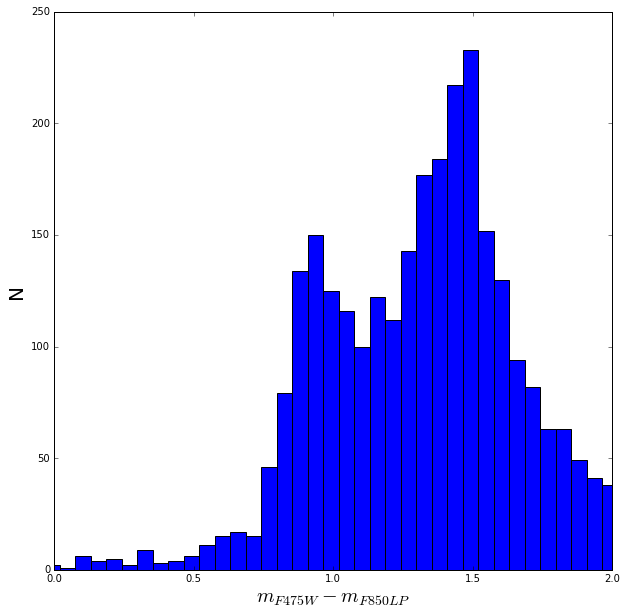

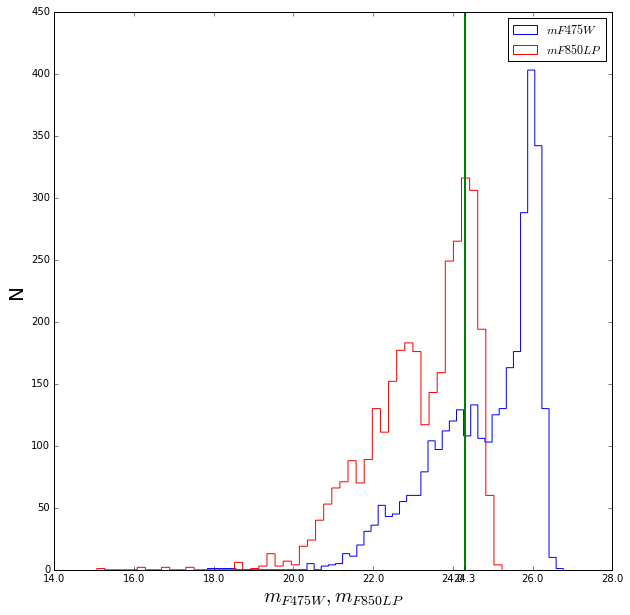

In [13]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from astropy.io import ascii

tbl = ascii.read('m87_match_f475w_f850lp.cat')

plt.figure(figsize=(10,10))
plt.hist(tbl["f475wMAG"] - tbl["f850lpMAG"], bins=220)
plt.xlabel("$m_{F475W} - m_{F850LP}$", fontsize=20)
plt.ylabel("N", fontsize=20)
plt.xlim(0, 2)

plt.show()
plt.close()

plt.figure(figsize=(10,10))
plt.hist(tbl["f475wMAG"], histtype = 'step', color='b',label='$mF475W$',bins=50)
plt.hist(tbl["f850lpMAG"], histtype = 'step', color='r',label='$mF850LP$',bins=50)

plt.legend()
plt.xticks(list(plt.xticks()[0]) + [24.3])

plt.axvline(x=24.3,linewidth=2, color='g')

plt.xlabel("$m_{F475W}, m_{F850LP}$", fontsize=20)
plt.ylabel("N", fontsize=20)

plt.show()
plt.close()

Para encontrar la distancia se recurre al dato de magnitud absoluta esperada de $-8.4$ ([Jordán et al (2006)](https://arxiv.org/abs/astro-ph/0609371)) y la magnitud aparente obtenida del histograma $24.3$

In [14]:
m = 24.3
dm = m+8.4
print dm
print 10**((dm+5)/5)

32.7
34673685.0453


Se obtiene que la distancia es 34.67 Mpc. Dada la distancia conocida (16.5 Mpc) se esperaría una magnitud aparente de 22.09 magnitudes. Se infiere que hubo algún error en la calibración que provocó que se obtuviera una distancia de más del doble de lo esperado.

### Chandra

Se decarga una imagen con 98.55ks de exposición desde el archivo de Chandra:
<img src="chandra.jpeg" width="500">
Se ejecuta sextractor en la imagen de Chandra, sin muchas configuraciones ni se hacen calibraciones de magnitud en vista de que solo se pretende saber si hay matches. De los 55 objetos detectados por sextractor todos tienen match en el catálogo del filtro F850W.

In [6]:
!sextractor chandra.fits -c chandra.sex

> 
----- SExtractor 2.19.5 started on 2016-11-28 at 23:14:14 with 1 thread

> Setting catalog parameters
> Reading detection filter
> Initializing catalog
> Looking for chandra.fits
----- Measuring from: chandra.fits [0/7]
      "NGC4486" / no ext. header / 1024x1024 / 32 bits (integers)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line:   64
> Setting up background map at line:  128
> Setting up background map at line:  192
> Setting up background map at line:  256
> Setting up background map at line:  320
> Setting up background map at line:  384
> Setting up background map at line:  448
> Setting up background map at line:  512
> Setting up background map at line:  576
> Setting up background map at line:  640
> Setting up background map at line:  704
> Setting up background map at line:  768
> Setting up background map at line:  832
> Setting up background map at line:  896
> Setting up background map at line:  960
> Filtering background 

In [9]:
RAchan = np.loadtxt('chandra.cat',usecols=(3,))
DEchan = np.loadtxt('chandra.cat',usecols=(4,))

# Match por parte de astropy. El catalogo de chandra contiene menos objetos
c = SkyCoord(ra=RAchan*u.degree, dec=DEchan*u.degree)  
catalog = SkyCoord(ra=RA850*u.degree, dec=DE850*u.degree)  
idx = c.match_to_catalog_sky(catalog)

# Del catalogo f850lp.cat se extraen las filas que indica el match
matches = list(idx[0])
f850lp = np.loadtxt('f850lp.cat')
chandra = np.loadtxt('chandra.cat')
out = []
  
j = 0
for i in matches:
    out.append(np.concatenate(
            [chandra[j],
             f850lp[i]+ 2.5*np.log10(0.538)- (1.472*BV)]))
    j = j+1

# Salida a archivo
np.savetxt('match_chandra.cat',out,
    fmt='%d\t%.4f\t%.4f\t%.7f\t%.7f\t%d\t%.4f\t%.4f\t%.7f\t%.7f',
    header='f475wN\tf475wMAG\tf475wMAGERR\tf475wALPHA\tf475wDELTA\tf850lpN\tf850lpMAG\tf850lpMAGERR\tf850lpALPHA\tf814wDELTA')

Es natural esperar emisión en rayos X puesto que en cúmulos globulares existen sistemas binarios de estrellas de baja masa en mayor número que en otros sistemas, dado que las estrellas tienden a agruparse en el centro y en un cúmulo hay entre 10 000 y 1 000 000 de ellas. En estos sistemas, una estrella acreta la otra produciendo evaporación de material y emisión de radiación en rayos X.
Además, los púlsares son muy comunes en cúmulos globulares si se considera que bien podrían haber evolucionado de las estrellas antes mencionadas.

Fuente: [X CANARY ISLANDS WINTER SCHOOL OF ASTROPHYSICS "Globular cluster" (Ramón Canal)](http://www.iac.es/gabinete/iacnoticias/winter98/xcanal.htm)